<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/AGENTIC-COMBINED-AGENTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Creating robust system with 12 sensors
✅ AE model loaded for sensor 0
✅ AE model loaded for sensor 1
✅ AE model loaded for sensor 2
✅ AE model loaded for sensor 3
✅ AE model loaded for sensor 4
✅ AE model loaded for sensor 5
✅ AE model loaded for sensor 6
✅ AE model loaded for sensor 7
✅ AE model loaded for sensor 8
✅ AE model loaded for sensor 9
✅ AE model loaded for sensor 10
✅ AE model loaded for sensor 11
✅ Created system: 12/12 models loaded
✅ Loaded MLP model from /content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_Daily.keras
AdaptiveWindowAgent adaptive_window_agent initialized



Sample 1
Master: {'system_anomaly': False, 'system_drift': False, 'system_needs_retrain': False, 'anomaly_rate': 0.0, 'drift_rate': 0.0, 'retrain_rate': 0.0}
Window: {'predicted_window': 2, 'event': None}
Coordinator: NORMAL {'anomaly_score': 0.0, 'drift_score': 0.0, 'sensor_anomaly_rate': 0.0, 'sensor_drift_rate': 0.0}

Sample 2
Master: {'system_anomaly': False, 'system_drift': False, 'system_needs_retrain': False, 'anomaly_rate': 0.0, 'drift_rate': 0.0, 'retrain_rate': 0.0}
Window: {'predicted_window': 2, 'event': None}
Coordinator: NORMAL {'anomaly_score': 0.0, 'drift_score': 0.0, 'sensor_anomaly_rate': 0.0, 'sensor_drift_rate': 0.0}

Sample 3
Master: {'system_anomaly': False, 'system_drift': False, 'system_needs_retrain': False, 'anomaly_rate': 0.0, 'drift_rate': 0.0, 'retrain_rate': 0.0}
Window: {'predicted_window': 1, 'event': None}
Coordinator: NORMAL {'anomaly_score': 0.0, 'drift_score': 0.0, 'sensor_anomaly_rate': 0.0, 'sensor_drift_rate': 0.0}

Sample 4
Master: {'system_anom

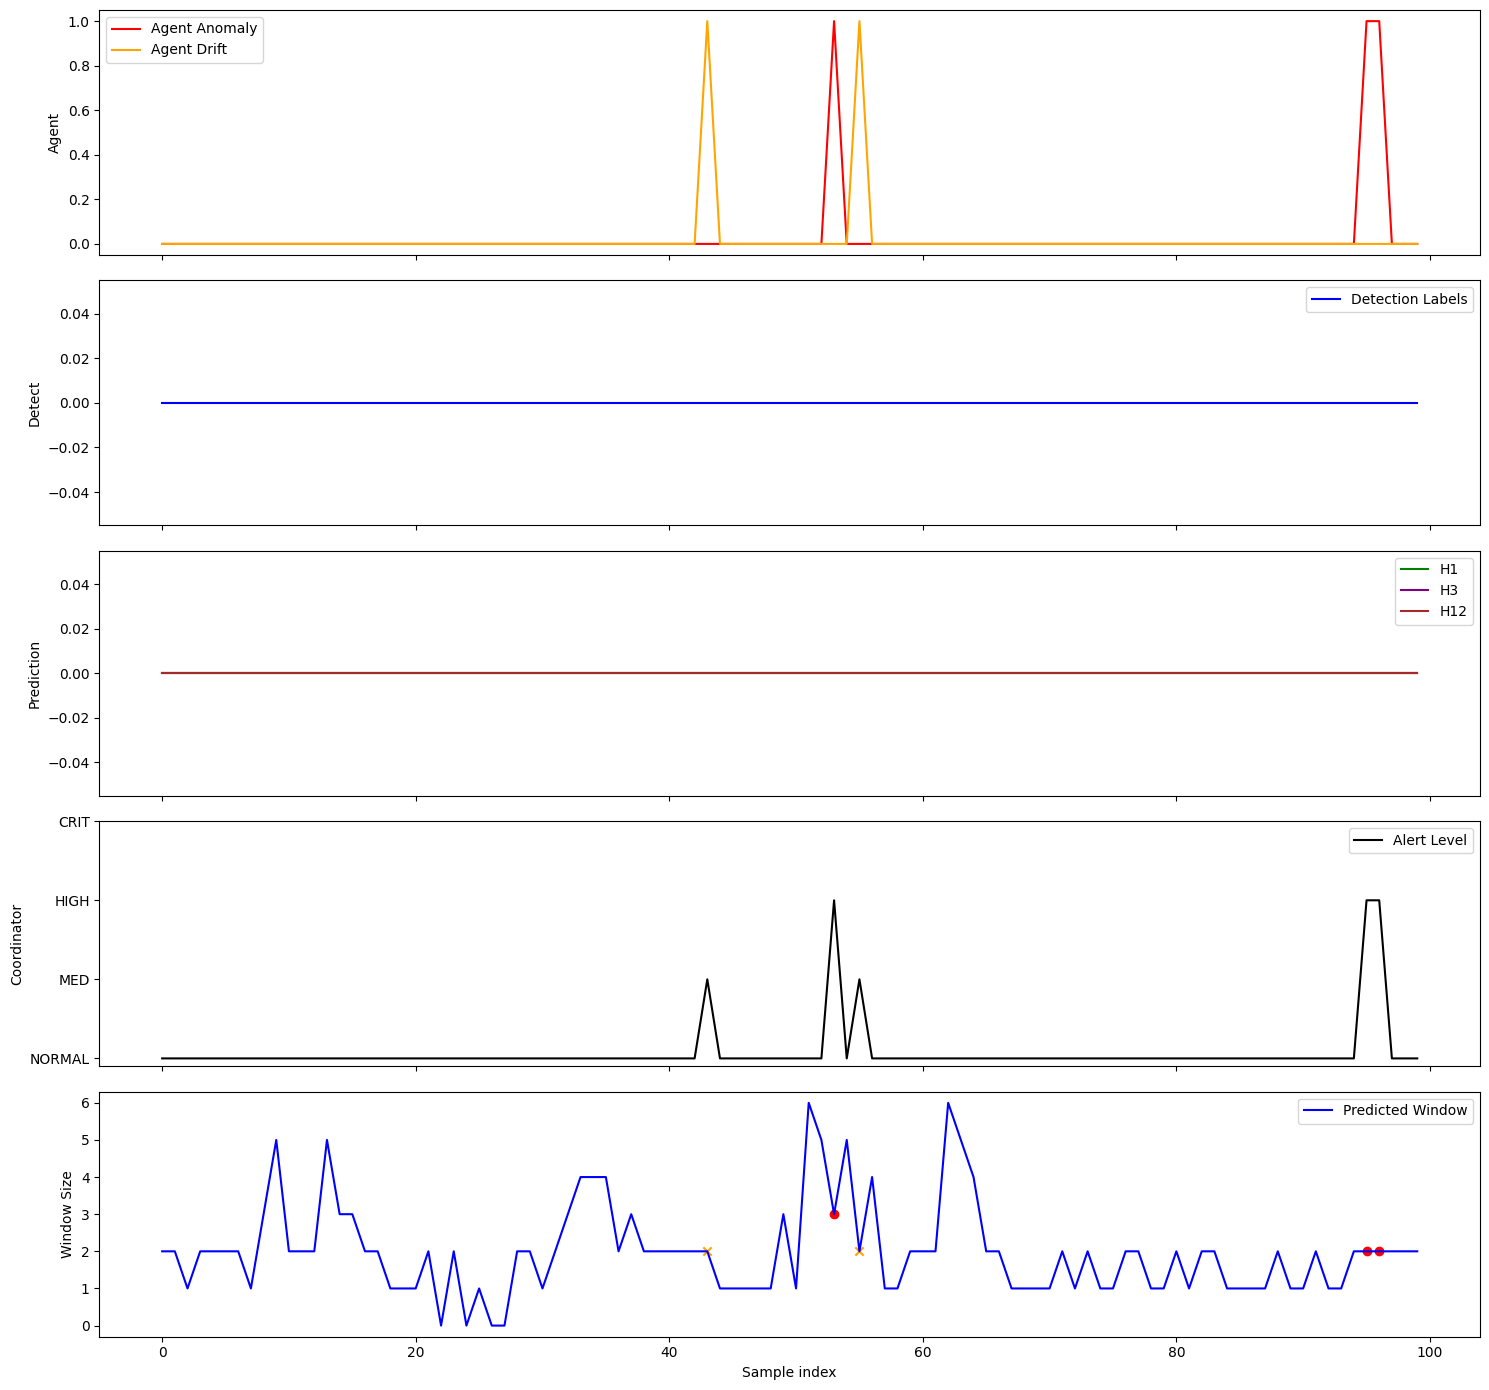

Detection anomaly indices: [ 359  360  361  362  363  364  365  366  367  368  369  370  371  372
  373  374  375  376  377  378  379  380  381  382 1367 1368 1369 1370
 1371 1372 1373 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531
 1532 1533 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545
 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559
 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573
 2486 2487 2488 2489 2490]
H+1 anomaly indices: [ 358 1366 1520 2485]
H+3 anomaly indices: [ 356  357  358 1364 1365 1366 1518 1519 1520 2483 2484 2485]
H+12 anomaly indices: [ 347  348  349  350  351  352  353  354  355  356  357  358 1355 1356
 1357 1358 1359 1360 1361 1362 1363 1364 1365 1366 1509 1510 1511 1512
 1513 1514 1515 1516 1517 1518 1519 1520 2474 2475 2476 2477 2478 2479
 2480 2481 2482 2483 2484 2485]


In [3]:
# ====== Imports ======
import numpy as np
import pandas as pd
import pickle, json, os, logging, warnings
from collections import deque
from typing import Dict, Any
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
import keras, tensorflow as tf
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ====== RobustSensorAgent & RobustMasterAgent ======
import pickle
import os
from collections import deque
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.spatial.distance import jensenshannon

# Deep learning
try:
    from tensorflow.keras.models import load_model
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False


# =====================================================
# ROBUST SENSOR AGENT - Observes ONE sensor with AE model
# =====================================================

class RobustSensorAgent:
    """
    Robust Sensor Agent for ONE sensor with advanced anomaly & drift detection.

    Loads pretrained AE model + metadata (scaler, baseline errors, rolling stats).
    Computes anomaly score via reconstruction error, applies adaptive thresholding,
    drift detection, and outputs robust anomaly/drift/retrain flags.
    """

    def __init__(self,
                 sensor_id: int,
                 model_path: str = None,
                 window_length: int = 50,
                 memory_size: int = 1000,
                 threshold_k: float = 2.0,
                 drift_threshold: float = 0.1):

        self.sensor_id = sensor_id
        self.window_length = window_length
        self.threshold_k = threshold_k
        self.drift_threshold = drift_threshold

        # Model & metadata
        self.model = None
        self.scaler = None
        self.is_model_loaded = False

        # Buffers
        self.error_memory = deque(maxlen=memory_size)
        self.data_memory = deque(maxlen=memory_size)
        self.recent_errors = deque(maxlen=100)

        # Rolling stats
        self.rolling_stats = {'mean': 0.0, 'std': 1.0, 'q95': 0.0, 'q99': 0.0}
        self.baseline_errors = None

        # Counters
        self.total_processed = 0
        self.anomalies_detected = 0
        self.drift_detected_count = 0
        self.last_stats_update = datetime.now()

        if model_path:
            self.load_model(model_path)

    def load_model(self, model_path: str) -> bool:
        """Load pretrained AE model + metadata."""
        try:
            if KERAS_AVAILABLE and model_path.endswith('.h5'):
                self.model = load_model(model_path, compile=False)

                # Metadata sidecar file
                metadata_path = model_path.replace('.h5', '_metadata.pkl')
                if os.path.exists(metadata_path):
                    with open(metadata_path, 'rb') as f:
                        metadata = pickle.load(f)
                   # self.scaler = metadata.get('scaler', StandardScaler())
                    self.rolling_stats = metadata.get('rolling_stats', self.rolling_stats)
                    if 'error_history' in metadata:
                        self.baseline_errors = np.array(metadata['error_history'])
            else:
                raise ValueError("Unsupported model format – expecting .h5 AE model")

            self.is_model_loaded = True
            print(f"✅ AE model loaded for sensor {self.sensor_id}")
            return True

        except Exception as e:
            print(f"❌ Failed to load AE model for sensor {self.sensor_id}: {e}")
            return False

    def observe(self, sensor_subsequence: np.ndarray) -> Dict:
        """Observe subsequence [window_length] and return anomaly/drift flags."""
        if not self.is_model_loaded:
            return {"sensor_id": self.sensor_id, "error": "no_model_loaded", "timestamp": datetime.now()}

        if len(sensor_subsequence) != self.window_length:
            return {"sensor_id": self.sensor_id,
                    "error": f"invalid_length_expected_{self.window_length}_got_{len(sensor_subsequence)}",
                    "timestamp": datetime.now()}

        # 1. Anomaly score
        anomaly_score = self._compute_robust_anomaly_score(sensor_subsequence)

        # 2. Update memory
        self.data_memory.append(sensor_subsequence.copy())
        self.error_memory.append(anomaly_score)
        self.recent_errors.append(anomaly_score)

        # 3. Update rolling stats periodically
        if len(self.error_memory) >= 50 and len(self.error_memory) % 10 == 0:
            self._update_rolling_stats(list(self.error_memory)[-50:])

        # 4. Flags
        is_anomaly = self._check_adaptive_anomaly(anomaly_score)
        drift_flag = self._check_advanced_drift()
        needs_retrain = self._check_retrain_need()
        confidence = self._compute_robust_confidence(anomaly_score)

        # 5. Update counters
        self.total_processed += 1
        if is_anomaly: self.anomalies_detected += 1
        if drift_flag: self.drift_detected_count += 1

        return {
            "sensor_id": self.sensor_id,
            "timestamp": datetime.now(),
            "is_anomaly": bool(is_anomaly),
            "drift_flag": bool(drift_flag),
            "needs_retrain_flag": bool(needs_retrain),
            "anomaly_score": float(anomaly_score),
            "confidence": float(confidence),
            "threshold_used": float(self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']),
            "anomaly_rate": self.anomalies_detected / max(1, self.total_processed),
            "drift_rate": self.drift_detected_count / max(1, self.total_processed)
        }

    def _compute_robust_anomaly_score(self, subsequence: np.ndarray) -> float:
        """Compute reconstruction error using AE model."""
        try:
            #data_scaled = self.scaler.transform(subsequence.reshape(-1, 1))
            X = subsequence.reshape(1, self.window_length, 1)  # [batch, timesteps, features]
            reconstruction = self.model.predict(X, verbose=0)
            error = mean_squared_error(subsequence.flatten(), reconstruction.flatten())
            return max(0.0, error)
        except Exception as e:
            print(f"⚠️ AE inference failed for sensor {self.sensor_id}: {e}")
            return np.var(subsequence)

    def _update_rolling_stats(self, errors: List[float]):
        errors_array = np.array(errors)
        self.rolling_stats['mean'] = np.mean(errors_array)
        self.rolling_stats['std'] = np.std(errors_array) + 1e-8
        self.rolling_stats['q95'] = np.percentile(errors_array, 95)
        self.rolling_stats['q99'] = np.percentile(errors_array, 99)
        self.last_stats_update = datetime.now()

    def _check_adaptive_anomaly(self, score: float) -> bool:
        threshold = self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']
        return score > threshold

    def _check_advanced_drift(self) -> bool:
        if self.baseline_errors is None or len(self.recent_errors) < 30:
            return False
        try:
            hist_baseline, bins = np.histogram(self.baseline_errors, bins=20, density=True)
            hist_recent, _ = np.histogram(list(self.recent_errors), bins=bins, density=True)
            hist_baseline += 1e-10; hist_recent += 1e-10
            hist_baseline /= hist_baseline.sum(); hist_recent /= hist_recent.sum()
            js_divergence = jensenshannon(hist_baseline, hist_recent)
            return js_divergence > self.drift_threshold
        except Exception:
            try:
                _, p_value = stats.ks_2samp(self.baseline_errors, list(self.recent_errors))
                return p_value < 0.05
            except:
                return False

    def _check_retrain_need(self) -> bool:
        if len(self.error_memory) < 100: return False
        recent_errors = list(self.error_memory)[-50:]
        threshold = self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']
        anomaly_rate = sum(1 for e in recent_errors if e > threshold) / len(recent_errors)
        criteria = [
            anomaly_rate > 0.3,
            self.drift_detected_count > 0.1 * self.total_processed,
            np.mean(recent_errors) > 2.0 * self.rolling_stats['mean'] if len(recent_errors) > 0 else False,
            (datetime.now() - self.last_stats_update).days > 7
        ]
        return sum(criteria) >= 2

    def _compute_robust_confidence(self, score: float) -> float:
        if self.rolling_stats['std'] == 0: return 0.5
        threshold = self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']
        distance_from_threshold = abs(score - threshold) / self.rolling_stats['std']
        return min(1.0, distance_from_threshold / 3.0)


# =====================================================
# ROBUST MASTER AGENT
# =====================================================

class RobustMasterAgent:
    """Aggregates sensor results, makes system-level anomaly/drift/retrain decisions."""
    def __init__(self, sensor_agents: List[RobustSensorAgent],
                 system_anomaly_threshold: float = 0.3,
                 drift_threshold: float = 0.2,
                 retrain_threshold: float = 0.15):
        self.sensor_agents = sensor_agents
        self.num_sensors = len(sensor_agents)
        self.system_anomaly_threshold = system_anomaly_threshold
        self.drift_threshold = drift_threshold
        self.retrain_threshold = retrain_threshold

    def process_system_input(self, system_subsequence: np.ndarray) -> Dict:
        """Process [window_length, num_sensors] multivariate subsequence."""
        timestamp = datetime.now()
        if system_subsequence.shape[1] != self.num_sensors:
            return {"error": f"Expected {self.num_sensors} sensors, got {system_subsequence.shape[1]}",
                    "timestamp": timestamp}

        # 1. Collect sensor observations
        sensor_results = []
        for i, agent in enumerate(self.sensor_agents):
            sensor_data = system_subsequence[:, i]
            result = agent.observe(sensor_data)
            sensor_results.append(result)

        # 2. Simple aggregation
        anomalies = sum(1 for r in sensor_results if r.get("is_anomaly"))
        drifts = sum(1 for r in sensor_results if r.get("drift_flag"))
        retrains = sum(1 for r in sensor_results if r.get("needs_retrain_flag"))

        anomaly_rate = anomalies / max(1, self.num_sensors)
        drift_rate = drifts / max(1, self.num_sensors)
        retrain_rate = retrains / max(1, self.num_sensors)

        system_decisions = {
            "system_anomaly": anomaly_rate >= self.system_anomaly_threshold,
            "system_drift": drift_rate >= self.drift_threshold,
            "system_needs_retrain": retrain_rate >= self.retrain_threshold,
            "anomaly_rate": anomaly_rate,
            "drift_rate": drift_rate,
            "retrain_rate": retrain_rate
        }

        return {
            "timestamp": timestamp,
            "sensor_results": sensor_results,
            "system_decisions": system_decisions
        }


# =====================================================
# SENSOR SYSTEM CREATION
# =====================================================

def create_robust_system(num_sensors: int, models_dir: str) -> Tuple[List[RobustSensorAgent], RobustMasterAgent]:
    """Create robust sensor system loading AE models + metadata."""
    print(f"🚀 Creating robust system with {num_sensors} sensors")
    sensor_agents = []
    for sensor_id in range(num_sensors):
        model_path = os.path.join(models_dir, f"sensor_{sensor_id}_model.h5")
        agent = RobustSensorAgent(sensor_id=sensor_id,
                                  model_path=model_path if os.path.exists(model_path) else None,
                                  window_length=50,
                                  memory_size=1000,
                                  threshold_k=2.0,
                                  drift_threshold=0.1)
        sensor_agents.append(agent)

    master = RobustMasterAgent(sensor_agents=sensor_agents,
                               system_anomaly_threshold=0.3,
                               drift_threshold=0.2,
                               retrain_threshold=0.15)
    print(f"✅ Created system: {len([a for a in sensor_agents if a.is_model_loaded])}/{num_sensors} models loaded")
    return sensor_agents, master

# ====== AdaptiveWindowAgent ======
# =====================================================
# AdaptiveWindowAgent (improved version)
# =====================================================
import numpy as np
import pandas as pd
import pickle, os, logging, datetime as dt
from collections import deque
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
import keras

logger = logging.getLogger(__name__)

class AdaptiveWindowAgent:
    """
    Adaptive Window Agent:
    - Predicts window size using MLP
    - Evaluates forecast with VAR
    - Monitors anomalies & drift with adaptive thresholds
    - Outputs severity scores + suppresses redundant events
    """

    def __init__(self, agent_id="adaptive_window_agent",
                 model_path=None, checkpoint_path=None):
        self.agent_id = agent_id
        self.model_path = model_path or "/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_Daily.keras"
        self.checkpoint_path = checkpoint_path

        # Core model
        self.model = None
        self.transformer = StandardScaler()
        self.transformer_fitted = False
        self.is_model_loaded = False

        # Histories
        self.prediction_history = deque(maxlen=1000)
        self.mse_history = deque(maxlen=200)
        self.mae_history = deque(maxlen=200)

        # Event detection params
        self.drift_detection_window = 20
        self.drift_threshold_mse = 1.5   # stricter
        self.drift_threshold_mae = 1.5
        self.consecutive_poor_predictions = 0
        self.cooldown_counter = 0

        # Stats
        self.performance_stats = {
            'total_predictions': 0,
            'avg_mse': 0.0,
            'avg_mae': 0.0,
            'last_retrain_time': None,
            'drift_events': 0,
            'anomaly_events': 0,
            'retraining_events': 0
        }

        # Retraining buffers
        self.retraining_data = {
            'x_buffer': deque(maxlen=10000),
            'y_buffer': deque(maxlen=10000)
        }

        self.load_model()
        print(f"AdaptiveWindowAgent {self.agent_id} initialized")

    # ------------------- Model -------------------

    def load_model(self):
        try:
            if os.path.exists(self.model_path):
                self.model = keras.models.load_model(self.model_path)
                self.is_model_loaded = True
                print(f"✅ Loaded MLP model from {self.model_path}")

                # Try to load transformer
                transformer_path = self.model_path.replace('.keras', '_transformer.pkl')
                if os.path.exists(transformer_path):
                    with open(transformer_path, 'rb') as f:
                        self.transformer = pickle.load(f)
                    self.transformer_fitted = True
                else:
                    # Fit transformer from true window labels
                    y_original = np.load(
                        "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/generated-data-true-window2.npy"
                    )
                    self.transformer.fit(y_original.reshape(-1, 1))
                    self.transformer_fitted = True
                    with open(transformer_path, 'wb') as f:
                        pickle.dump(self.transformer, f)
                    print("⚠️ No transformer found, fitted a new one.")
            else:
                print(f"❌ Model not found at {self.model_path}")
        except Exception as e:
            print(f"❌ Error loading model: {e}")

    # ------------------- Forecast Eval -------------------
    def evaluate_forecast_performance(self, sequence_3d, predicted_window, n_future=1):
        try:
            df = pd.DataFrame(sequence_3d, columns=[f'V{i+1}' for i in range(sequence_3d.shape[1])])
            df_train, df_test = df[:-n_future], df[-n_future:]

            # Drop constant cols
            constant_cols = [c for c in df_train.columns if df_train[c].nunique() <= 1]
            df_train = df_train.drop(columns=constant_cols, errors="ignore")
            df_test = df_test.drop(columns=constant_cols, errors="ignore")

            # If too few variables, fall back immediately
            if len(df_train.columns) < 1:
                return self._persistence_forecast(df, df_test)

            k = min(predicted_window, len(df_train) - 2)
            if k < 1: k = 1

            # Try VAR
            try:
                model = VAR(df_train)
                model_fitted = model.fit(maxlags=k, trend="c")
                forecast_input = df_train.values[-model_fitted.k_ar:]
                fc = model_fitted.forecast(y=forecast_input, steps=n_future)
                df_forecast = pd.DataFrame(fc, index=df.index[-n_future:], columns=df_train.columns)

                actual = df_test[df_forecast.columns].values.flatten()
                predicted = df_forecast.values.flatten()

            except Exception:
                # Try AutoReg
                try:
                    from statsmodels.tsa.ar_model import AutoReg
                    col = df_train.columns[0]
                    model = AutoReg(df_train[col], lags=min(k, len(df_train)//2)).fit()
                    predicted = model.predict(start=len(df_train), end=len(df_train)+n_future-1).values
                    actual = df_test[col].values
                except Exception:
                    # Fallback to persistence
                    return self._persistence_forecast(df, df_test)

            mse = np.mean((actual - predicted) ** 2)
            mae = np.mean(np.abs(actual - predicted))

            # If forecast is unstable, fallback
            if np.isnan(mse) or np.isnan(mae) or mse > 10 or mae > 10:
                return self._persistence_forecast(df, df_test)

            return {
                'mse': float(mse),
                'mae': float(mae),
                'forecast_success': True,
                'actual_values': actual.tolist(),
                'predicted_values': predicted.tolist(),
                'used_columns': list(df_test.columns)
            }

        except Exception:
            return self._persistence_forecast(df, df_test)

# ------------------- Persistence fallback -------------------

    def _persistence_forecast(self, df, df_test):
        """Simple last-value-carried-forward forecast."""
        try:
            last_values = df.iloc[-1].values
            predicted = np.tile(last_values, (len(df_test), 1))
            actual = df_test.values.flatten()

            mse = np.mean((actual - predicted.flatten()) ** 2)
            mae = np.mean(np.abs(actual - predicted.flatten()))

            return {
                'mse': float(mse),
                'mae': float(mae),
                'forecast_success': True,
                'actual_values': actual.tolist(),
                'predicted_values': predicted.flatten().tolist(),
                'used_columns': list(df_test.columns),
                'note': 'persistence_fallback'
            }
        except Exception as e:
            return {'mse': 9999, 'mae': 9999, 'forecast_success': True, 'error': str(e), 'note': 'persistence_fallback_failed'}



    # ------------------- Prediction -------------------

    def predict_window_size(self, feature_vector, sequence_3d):
        if not self.is_model_loaded:
            return {'predicted_window': 20, 'error': "Model not loaded"}

        try:
            if feature_vector.ndim == 1:
                feature_vector = feature_vector.reshape(1, -1)

            pred_raw = self.model.predict(feature_vector, verbose=0)
            if self.transformer_fitted:
                predicted_window = int(round(self.transformer.inverse_transform(pred_raw)[0, 0]))
            else:
                predicted_window = int(round(pred_raw[0, 0]))

            # Evaluate
            forecast_metrics = self.evaluate_forecast_performance(sequence_3d, predicted_window, n_future=1)

            if forecast_metrics.get("forecast_success", False):
                self.mse_history.append(forecast_metrics["mse"])
                self.mae_history.append(forecast_metrics["mae"])
                self.performance_stats['total_predictions'] += 1
                self.performance_stats['avg_mse'] = np.mean(self.mse_history)
                self.performance_stats['avg_mae'] = np.mean(self.mae_history)

            # Event check
            event, sev = self._check_for_event()

            # Save history
            record = {
                'timestamp': dt.datetime.now(),
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'event_type': event,
                'severity': sev
            }
            self.prediction_history.append(record)

            return {
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'event_type': event,
                'severity': sev,
                'performance_stats': self.get_recent_performance()
            }
        except Exception as e:
            return {'predicted_window': 20, 'error': str(e)}

    # ------------------- Event Logic -------------------

    def _check_for_event(self):
        if len(self.mse_history) < self.drift_detection_window:
            return None, 0.0

        mse_vals = np.array(self.mse_history)[-self.drift_detection_window:]
        mae_vals = np.array(self.mae_history)[-self.drift_detection_window:]

        # Rolling stats
        mean_mse, std_mse = np.mean(mse_vals), np.std(mse_vals) + 1e-8
        last_mse = mse_vals[-1]

        # Normalized error
        norm_error = (last_mse - mean_mse) / std_mse

        # Severity
        anomaly_severity = max(0, norm_error)
        drift_severity = max(0, (np.mean(mse_vals) / (np.median(mse_vals)+1e-5)) - 1)

        # Check anomaly
        if last_mse > mean_mse + 2.0 * std_mse:
            self.performance_stats['anomaly_events'] += 1
            return "ANOMALY", anomaly_severity

        # Check drift (with persistence + cooldown)
        ema_mse = 0.3*np.mean(mse_vals) + 0.7*np.median(mse_vals)
        ema_mae = 0.3*np.mean(mae_vals) + 0.7*np.median(mae_vals)
        mse_ratio = ema_mse / max(np.median(mse_vals), 1e-5)
        mae_ratio = ema_mae / max(np.median(mae_vals), 1e-5)

        if mse_ratio > self.drift_threshold_mse and mae_ratio > self.drift_threshold_mae:
            self.consecutive_poor_predictions += 1
            if self.consecutive_poor_predictions >= 5 and self.cooldown_counter == 0:
                self.performance_stats['drift_events'] += 1
                self.cooldown_counter = 10
                return "DRIFT", drift_severity
        else:
            self.consecutive_poor_predictions = 0

        if self.cooldown_counter > 0:
            self.cooldown_counter -= 1

        return None, 0.0

    # ------------------- Helpers -------------------

    def get_recent_performance(self):
        successful_predictions = [
            p for p in list(self.prediction_history)[-50:]
            if p.get('forecast_metrics', {}).get('forecast_success', False)
        ]
        return {
            'total_predictions': len(self.prediction_history),
            'successful_predictions': len(successful_predictions),
            'success_rate': len(successful_predictions) / max(len(self.prediction_history), 1),
            'drift_events': self.performance_stats['drift_events'],
            'anomaly_events': self.performance_stats['anomaly_events'],
            'retraining_events': self.performance_stats['retraining_events'],
            'recent_mse': float(np.mean(list(self.mse_history)[-10:])) if self.mse_history else 0,
            'avg_mse': float(np.mean(self.mse_history)) if self.mse_history else 0,
            'recent_mae': float(np.mean(list(self.mae_history)[-10:])) if self.mae_history else 0,
            'avg_mae': float(np.mean(self.mae_history)) if self.mae_history else 0,
            'transformer_fitted': self.transformer_fitted
        }


    def save_performance_state(self, filepath: str):
        """Save performance statistics + prediction history to JSON"""
        try:
            state = {
                'performance_stats': self.performance_stats.copy(),
                'prediction_history': list(self.prediction_history)[-100:],  # last 100
                'mse_history': list(self.mse_history),
                'mae_history': list(self.mae_history),
                'transformer_fitted': self.transformer_fitted
            }
            import json
            with open(filepath, 'w') as f:
                json.dump(state, f, indent=2, default=str)
            print(f"✅ Performance state saved to {filepath}")
        except Exception as e:
            print(f"❌ Failed to save performance state: {e}")

# ==================== PLOTTING ====================
import matplotlib.pyplot as plt

def plot_all_features_forecasts(test_sequences, agent, max_features=12):
    all_actual, all_forecast, event_points = [], [], []
    for i, seq in enumerate(test_sequences):
        result = agent.predict_window_size(seq.flatten(), seq)
        fm = result.get("forecast_metrics", {})
        if not fm.get("forecast_success", False): continue
        actual_row = [np.nan] * max_features
        forecast_row = [np.nan] * max_features
        for j, col in enumerate(fm.get("used_columns", [])):
            idx = int(col.replace("V", "")) - 1
            if idx < max_features:
                actual_row[idx] = fm["actual_values"][j]
                forecast_row[idx] = fm["predicted_values"][j]
        all_actual.append(actual_row)
        all_forecast.append(forecast_row)
        if result.get("event_type", None):
            event_points.append((i, result["event_type"]))
    if not all_actual: return
    actual_matrix = np.array(all_actual)
    forecast_matrix = np.array(all_forecast)
    timestamps = np.arange(len(actual_matrix))
    fig, axes = plt.subplots(max_features, 1, figsize=(12, 2.5 * max_features), sharex=True)
    for idx, ax in enumerate(axes):
        ax.plot(timestamps, actual_matrix[:, idx], label="Actual", marker="o", alpha=0.6)
        ax.plot(timestamps, forecast_matrix[:, idx], label="Forecast", marker="x", alpha=0.6)
        for (t, etype) in event_points:
            ax.scatter(t, actual_matrix[t, idx], color="red" if etype=="ANOMALY" else "orange",
                       marker="D", label=etype if idx==0 else "")
        ax.set_ylabel(f"V{idx+1}"); ax.grid(True, alpha=0.3)
        if idx == 0: ax.legend()
    axes[-1].set_xlabel("Sequence index")
    plt.tight_layout(); plt.show()

# ====== CoordinatorAgent ======

class CoordinatorAgent:
    """
    Coordinator Agent - orchestrates outputs from:
      1. RobustMasterAgent (sensor-level aggregation)
      2. AdaptiveWindowAgent (global window-level perspective)

    Combines them into a final system decision:
      - True anomalies (local + global agreement)
      - Concept drift (global window instability)
      - Retraining triggers
    """

    def __init__(self, anomaly_weight: float = 0.6, window_weight: float = 0.4):
        self.anomaly_weight = anomaly_weight
        self.window_weight = window_weight
        self.history = []

    def fuse(self, master_output: dict, window_output: dict) -> dict:
        timestamp = datetime.now()

        # Master outputs
        sys_dec = master_output.get("system_decisions", {})
        sys_anomaly = sys_dec.get("system_anomaly", False)
        sys_drift = sys_dec.get("system_drift", False)
        sys_retrain = sys_dec.get("system_needs_retrain", False)
        anomaly_rate = sys_dec.get("anomaly_rate", 0.0)
        drift_rate = sys_dec.get("drift_rate", 0.0)

        # Window outputs
        win_anomaly = window_output.get("window_anomaly_flag", False) \
                      or (window_output.get("event_type") == "ANOMALY")
        win_drift = window_output.get("window_drift_flag", False) \
                    or (window_output.get("event_type") == "DRIFT")
        predicted_window = window_output.get("predicted_window", None)

        # Fusion logic
        anomaly_score = (
            self.anomaly_weight * anomaly_rate +
            self.window_weight * (1.0 if win_anomaly else 0.0)
        )
        drift_score = (
            self.anomaly_weight * drift_rate +
            self.window_weight * (1.0 if win_drift else 0.0)
        )

        final_anomaly = anomaly_score >= 0.3 or (sys_anomaly and win_anomaly)
        final_drift = drift_score >= 0.2 or (sys_drift or win_drift)
        final_retrain = sys_retrain or (win_drift and anomaly_score > 0.2)

        if final_anomaly and final_drift:
            alert = "CRITICAL"
        elif final_anomaly:
            alert = "HIGH"
        elif final_drift:
            alert = "MEDIUM"
        else:
            alert = "NORMAL"

        decision = {
            "timestamp": timestamp,
            "final_anomaly": final_anomaly,
            "final_drift": final_drift,
            "final_retrain": final_retrain,
            "alert_level": alert,
            "scores": {
                "anomaly_score": anomaly_score,
                "drift_score": drift_score,
                "sensor_anomaly_rate": anomaly_rate,
                "sensor_drift_rate": drift_rate
            },
            "window_agent": {
                "predicted_window": predicted_window,
                "window_anomaly": win_anomaly,
                "window_drift": win_drift
            }
        }

        self.history.append(decision)
        return decision

##################################################
def extract_flags(entry):
    # Coordinator flags
    if "coordinator" in entry:
        coord = entry["coordinator"]
        return int(coord.get("final_anomaly", False)), int(coord.get("final_drift", False))

    # Master flags
    if "master" in entry and "system_decisions" in entry["master"]:
        sys = entry["master"]["system_decisions"]
        return int(sys.get("system_anomaly", False)), int(sys.get("system_drift", False))

    return 0, 0
##################################################

##################################################
#GROUND TRUTH ANOMALY VS WHICH AGENT AGENT IS RIGHT
############################################################
import matplotlib.pyplot as plt
import numpy as np

def plot_agent_vs_groundtruth(
    results,
    detection_labels=None,
    h1_labels=None,
    h3_labels=None,
    h12_labels=None,
    max_samples=200
):
    """
    Plot comparison between agent decisions, ground-truth labels,
    coordinator outputs, and AdaptiveWindowAgent predictions.
    """

    n = min(max_samples, len(results))
    t = np.arange(n)

    # Extract coordinator anomaly/drift
    agent_anomaly = [1 if r["coordinator"]["final_anomaly"] else 0 for r in results[:n]]
    agent_drift   = [1 if r["coordinator"]["final_drift"] else 0 for r in results[:n]]

    # Ground-truth labels
    det = detection_labels[:n] if detection_labels is not None else None
    h1  = h1_labels[:n] if h1_labels is not None else None
    h3  = h3_labels[:n] if h3_labels is not None else None
    h12 = h12_labels[:n] if h12_labels is not None else None

    # Window agent outputs
    window_sizes  = [r["window"]["predicted_window"] for r in results[:n]]
    window_events = [r["window"].get("event_type") for r in results[:n]]

    # ---- Create subplots ----
    fig, axes = plt.subplots(5, 1, figsize=(15, 14), sharex=True)

    # Agent outputs
    axes[0].plot(t, agent_anomaly, label="Agent Anomaly", color="red")
    axes[0].plot(t, agent_drift,   label="Agent Drift", color="orange")
    axes[0].set_ylabel("Agent")
    axes[0].legend()

    # Detection labels
    if det is not None:
        axes[1].plot(t, det, label="Detection Labels", color="blue")
        axes[1].set_ylabel("Detect")
        axes[1].legend()

    # Prediction labels (1h, 3h, 12h)
    if h1 is not None:
        axes[2].plot(t, h1, label="H1", color="green")
    if h3 is not None:
        axes[2].plot(t, h3, label="H3", color="purple")
    if h12 is not None:
        axes[2].plot(t, h12, label="H12", color="brown")
    axes[2].set_ylabel("Prediction")
    axes[2].legend()

    # Coordinator alert level
    alert_map = {"NORMAL": 0, "MEDIUM": 1, "HIGH": 2, "CRITICAL": 3}
    alerts = [alert_map.get(r["coordinator"]["alert_level"], 0) for r in results[:n]]
    axes[3].plot(t, alerts, label="Alert Level", color="black")
    axes[3].set_yticks([0,1,2,3])
    axes[3].set_yticklabels(["NORMAL","MED","HIGH","CRIT"])
    axes[3].set_ylabel("Coordinator")
    axes[3].legend()

    # AdaptiveWindowAgent subplot
    axes[4].plot(t, window_sizes, label="Predicted Window", color="blue")

    # Mark drift/anomaly events
    for i, evt in enumerate(window_events):
        if evt == "DRIFT":
            axes[4].scatter(i, window_sizes[i], color="orange", marker="x", label="Window Drift" if i==0 else "")
        elif evt == "ANOMALY":
            axes[4].scatter(i, window_sizes[i], color="red", marker="o", label="Window Anomaly" if i==0 else "")

    # Overlay ground-truth fault events (vertical lines)
    if det is not None:
        for i, val in enumerate(det):
            if val == 1:
                axes[4].axvline(i, color="red", linestyle="--", alpha=0.3, label="Fault (Detection)" if i==0 else "")
    if h1 is not None:
        for i, val in enumerate(h1):
            if val == 1:
                axes[4].axvline(i, color="green", linestyle="--", alpha=0.2, label="Fault (H1)" if i==0 else "")
    if h3 is not None:
        for i, val in enumerate(h3):
            if val == 1:
                axes[4].axvline(i, color="purple", linestyle="--", alpha=0.2, label="Fault (H3)" if i==0 else "")
    if h12 is not None:
        for i, val in enumerate(h12):
            if val == 1:
                axes[4].axvline(i, color="brown", linestyle="--", alpha=0.2, label="Fault (H12)" if i==0 else "")

    axes[4].set_ylabel("Window Size")
    axes[4].legend()

    axes[-1].set_xlabel("Sample index")
    plt.tight_layout()
    plt.show()

# =========================
# DEMO LOOP
# =========================

if __name__ == "__main__":
    models_dir = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/sensor/model"
    mlp_path = "/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_Daily.keras"
    data_path = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy"



    # create agents
    sensor_agents, master = create_robust_system(num_sensors=12, models_dir=models_dir)
    window_agent = AdaptiveWindowAgent(model_path=mlp_path)
    coordinator = CoordinatorAgent()

    # load test data
    subsequences = np.load(data_path)
    holdout_value = 100
    holdout = subsequences[1100:1200]

    results = []

    for i, seq in enumerate(holdout, 1):
        features = seq.flatten()
        master_out = master.process_system_input(seq)
        window_out = window_agent.predict_window_size(features, seq)
        final = coordinator.fuse(master_out, window_out)
        results.append({
        "master": master_out,
        "window": window_out,
        "coordinator": final
        })

        print("\n" + "="*60)
        print(f"Sample {i}")
        print("Master:", master_out["system_decisions"])
        print("Window:", {"predicted_window": window_out.get("predicted_window"),
                          "event": window_out.get("event_type")})
        print("Coordinator:", final["alert_level"], final["scores"])

    anomaly_labels = np.load("/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/anomaly_labels_detection.npy")
    h1_labels = np.load("/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/anomaly_labels_H1.npy")
    h3_labels = np.load("/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/anomaly_labels_H3.npy")
    h12_labels = np.load("/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/anomaly_labels_H12.npy")

    detection_labels_test = anomaly_labels[1100:1200]
    h1_labels_test = h1_labels[1100:1200]
    h3_labels_test = h3_labels[1100:1200]
    h12_labels_test = h12_labels[1100:1200]

    plot_agent_vs_groundtruth(
        results,
        detection_labels=detection_labels_test,
        h1_labels=h1_labels_test,
        h3_labels=h3_labels_test,
        h12_labels=h12_labels_test,
        max_samples=200   # optional
    )


    ############Optional - find where anomalies lie**************
    print("Detection anomaly indices:", np.where(anomaly_labels == 1)[0])
    print("H+1 anomaly indices:", np.where(h1_labels == 1)[0])
    print("H+3 anomaly indices:", np.where(h3_labels == 1)[0])
    print("H+12 anomaly indices:", np.where(h12_labels == 1)[0])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')